<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->


# Advanced Learning Rate Schedules

Given the importance of learning rate and the learning rate schedule for training neural networks, there have been a number of research papers published recently on the subject. Although many practitioners are using simple learning rate schedules such as stepwise decay, research has shown that there are other strategies that work better in most situations. We implement a number of different schedule shapes in this tutorial and introduce cyclical schedules.

See the "Learning Rate Schedules" tutorial for a more basic overview of learning rates, and an example of how to use them while training your own models.

In [1]:
%matplotlib inline
import copy
import math
import mxnet as mx
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_schedule(schedule_fn, iterations=1500):
    # Iteration count starting at 1
    iterations = [i+1 for i in range(iterations)]
    lrs = [schedule_fn(i) for i in iterations]
    plt.scatter(iterations, lrs)
    plt.xlabel("Iteration")
    plt.ylabel("Learning Rate")
    plt.show()

## Custom Schedule Shapes

### (Slanted) Triangular

While trying to push the boundaries of batch size for faster training, [Priya Goyal et al. (2017)](https://arxiv.org/abs/1706.02677) found that having a smooth linear warm up in the learning rate at the start of training improved the stability of the optimizer and lead to better solutions. It was found that a smooth increases gave improved performance over stepwise increases.

We look at "warm-up" in more detail later in the tutorial, but this could be viewed as a specific case of the **"triangular"** schedule that was proposed by [Leslie N. Smith (2015)](https://arxiv.org/abs/1506.01186). Quite simply, the schedule linearly increases then decreases between a lower and upper bound. Originally it was suggested this schedule be used as part of a cyclical schedule but more recently researchers have been using a single cycle.

One adjustment proposed by [Jeremy Howard, Sebastian Ruder (2018)](https://arxiv.org/abs/1801.06146) was to change the ratio between the increasing and decreasing stages, instead of the 50:50 split. Changing the increasing fraction (`inc_fraction!=0.5`) leads to a **"slanted triangular"** schedule. Using `inc_fraction<0.5` tends to give better results.

In [3]:
class TriangularSchedule():
    def __init__(self, min_lr, max_lr, cycle_length, inc_fraction=0.5):
        """
        min_lr: lower bound for learning rate (float)
        max_lr: upper bound for learning rate (float)
        cycle_length: iterations between start and finish (int)
        inc_fraction: fraction of iterations spent in increasing stage (float)
        """
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.cycle_length = cycle_length
        self.inc_fraction = inc_fraction

    def __call__(self, iteration):
        if iteration <= self.cycle_length*self.inc_fraction:
            unit_cycle = iteration * 1 / (self.cycle_length * self.inc_fraction)
        elif iteration <= self.cycle_length:
            unit_cycle = (self.cycle_length - iteration) * 1 / (self.cycle_length * (1 - self.inc_fraction))
        else:
            unit_cycle = 0
        adjusted_cycle = (unit_cycle * (self.max_lr - self.min_lr)) + self.min_lr
        return adjusted_cycle

We look an example of a slanted triangular schedule that increases from a learning rate of 1 to 2, and back to 1 over 1000 iterations. Since we set `inc_fraction=0.2`, 200 iterations are used for the increasing stage, and 800 for the decreasing stage. After this, the schedule stays at the lower bound indefinitely.

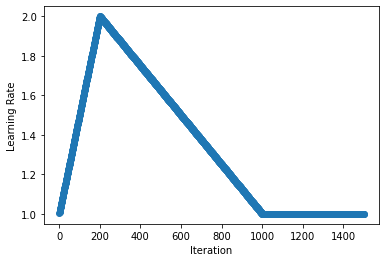

In [4]:
schedule = TriangularSchedule(min_lr=1, max_lr=2, cycle_length=1000, inc_fraction=0.2)
plot_schedule(schedule)

![lr adv triangular](https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/doc/tutorials/lr_schedules/adv_triangular.png) <!--notebook-skip-line-->


### Cosine

Continuing with the idea that smooth decay profiles give improved performance over stepwise decay, [Ilya Loshchilov, Frank Hutter (2016)](https://arxiv.org/abs/1608.03983) used **"cosine annealing"** schedules to good effect. As with triangular schedules, the original idea was that this should be used as part of a cyclical schedule, but we begin by implementing the cosine annealing component before the full Stochastic Gradient Descent with Warm Restarts (SGDR) method later in the tutorial.

In [5]:
class CosineAnnealingSchedule():
    def __init__(self, min_lr, max_lr, cycle_length):
        """
        min_lr: lower bound for learning rate (float)
        max_lr: upper bound for learning rate (float)
        cycle_length: iterations between start and finish (int)
        """
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.cycle_length = cycle_length

    def __call__(self, iteration):
        if iteration <= self.cycle_length:
            unit_cycle = (1 + math.cos(iteration * math.pi / self.cycle_length)) / 2
            adjusted_cycle = (unit_cycle * (self.max_lr - self.min_lr)) + self.min_lr
            return adjusted_cycle
        else:
            return self.min_lr

We look at an example of a cosine annealing schedule that smoothing decreases from a learning rate of 2 to 1 across 1000 iterations. After this, the schedule stays at the lower bound indefinietly.

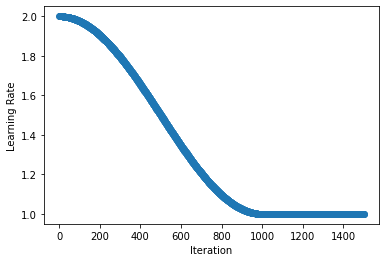

In [6]:
schedule = CosineAnnealingSchedule(min_lr=1, max_lr=2, cycle_length=1000)
plot_schedule(schedule)

![lr adv cosine](https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/doc/tutorials/lr_schedules/adv_cosine.png) <!--notebook-skip-line-->


## Custom Schedule Modifiers

We now take a look some adjustments that can be made to existing schedules. We see how to add linear warm-up and its compliment linear cool-down, before using this to implement the "1-Cycle" schedule used by [Leslie N. Smith, Nicholay Topin (2017)](https://arxiv.org/abs/1708.07120) for "super-convergence". We then look at cyclical schedules and implement the original cyclical schedule from [Leslie N. Smith (2015)](https://arxiv.org/abs/1506.01186) before finishing with a look at ["SGDR: Stochastic Gradient Descent with Warm Restarts" by Ilya Loshchilov, Frank Hutter (2016)](https://arxiv.org/abs/1608.03983).

Unlike the schedules above and those implemented in `mx.lr_scheduler`, these classes are designed to modify existing schedules so they take the argument `schedule` (for initialized schedules) or `schedule_class` when being initialized.

### Warm-Up

Using the idea of linear warm-up of the learning rate proposed in ["Accurate, Large Minibatch SGD: Training ImageNet in 1 Hour" by Priya Goyal et al. (2017)](https://arxiv.org/abs/1706.02677), we implement a wrapper class that adds warm-up to an existing schedule. Going from `start_lr` to the initial learning rate of the `schedule` over `length` iterations, this adjustment is useful when training with large batch sizes.

In [7]:
class LinearWarmUp():
    def __init__(self, schedule, start_lr, length):
        """
        schedule: a pre-initialized schedule (e.g. TriangularSchedule(min_lr=0.5, max_lr=2, cycle_length=500))
        start_lr: learning rate used at start of the warm-up (float)
        length: number of iterations used for the warm-up (int)
        """
        self.schedule = schedule
        self.start_lr = start_lr
        # calling mx.lr_scheduler.LRScheduler effects state, so calling a copy
        self.finish_lr = copy.copy(schedule)(0)
        self.length = length

    def __call__(self, iteration):
        if iteration <= self.length:
            return iteration * (self.finish_lr - self.start_lr)/(self.length) + self.start_lr
        else:
            return self.schedule(iteration - self.length)

As an example, we add a linear warm-up of the learning rate (from 0 to 1 over 250 iterations) to a stepwise decay schedule. We first create the `MultiFactorScheduler` (and set the `base_lr`) and then pass it to `LinearWarmUp` to add the warm-up at the start. We can use `LinearWarmUp` with any other schedule including `CosineAnnealingSchedule`.

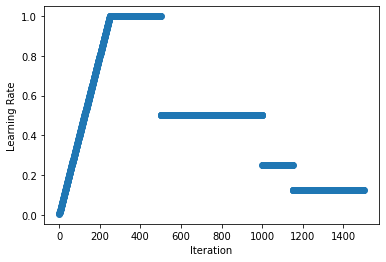

In [8]:
schedule = mx.lr_scheduler.MultiFactorScheduler(step=[250, 750, 900], factor=0.5)
schedule.base_lr = 1
schedule = LinearWarmUp(schedule, start_lr=0, length=250)
plot_schedule(schedule)

![lr adv warmup](https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/doc/tutorials/lr_schedules/adv_warmup.png) <!--notebook-skip-line-->


### Cool-Down

Similarly, we could add a linear cool-down period to our schedule and this is used in the "1-Cycle" schedule proposed by [Leslie N. Smith, Nicholay Topin (2017)](https://arxiv.org/abs/1708.07120) to train neural networks very quickly in certain circumstances (coined "super-convergence"). We reduce the learning rate from its value at `start_idx` of `schedule` to `finish_lr` over a period of `length`, and then maintain `finish_lr` thereafter.

In [9]:
class LinearCoolDown():
    def __init__(self, schedule, finish_lr, start_idx, length):
        """
        schedule: a pre-initialized schedule (e.g. TriangularSchedule(min_lr=0.5, max_lr=2, cycle_length=500))
        finish_lr: learning rate used at end of the cool-down (float)
        start_idx: iteration to start the cool-down (int)
        length: number of iterations used for the cool-down (int)
        """
        self.schedule = schedule
        # calling mx.lr_scheduler.LRScheduler effects state, so calling a copy
        self.start_lr = copy.copy(self.schedule)(start_idx)
        self.finish_lr = finish_lr
        self.start_idx = start_idx
        self.finish_idx = start_idx + length
        self.length = length

    def __call__(self, iteration):
        if iteration <= self.start_idx:
            return self.schedule(iteration)
        elif iteration <= self.finish_idx:
            return (iteration - self.start_idx) * (self.finish_lr - self.start_lr) / (self.length) + self.start_lr
        else:
            return self.finish_lr

As an example, we apply learning rate cool-down to a `MultiFactorScheduler`. Starting the cool-down at iteration 1000, we reduce the learning rate linearly from 0.125 to 0.001 over 500 iterations, and hold the learning rate at 0.001 after this.

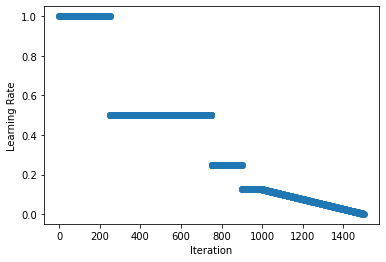

In [10]:
schedule = mx.lr_scheduler.MultiFactorScheduler(step=[250, 750, 900], factor=0.5)
schedule.base_lr = 1
schedule = LinearCoolDown(schedule, finish_lr=0.001, start_idx=1000, length=500)
plot_schedule(schedule)

![lr adv cooldown](https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/doc/tutorials/lr_schedules/adv_cooldown.png) <!--notebook-skip-line-->


#### 1-Cycle: for "Super-Convergence"

So we can implement the "1-Cycle" schedule proposed by [Leslie N. Smith, Nicholay Topin (2017)](https://arxiv.org/abs/1708.07120) we use a single and symmetric cycle of the triangular schedule above (i.e. `inc_fraction=0.5`), followed by a cool-down period of `cooldown_length` iterations.

In [11]:
class OneCycleSchedule():
    def __init__(self, start_lr, max_lr, cycle_length, cooldown_length=0, finish_lr=None):
        """
        start_lr: lower bound for learning rate in triangular cycle (float)
        max_lr: upper bound for learning rate in triangular cycle (float)
        cycle_length: iterations between start and finish of triangular cycle: 2x 'stepsize' (int)
        cooldown_length: number of iterations used for the cool-down (int)
        finish_lr: learning rate used at end of the cool-down (float)
        """
        if (cooldown_length > 0) and (finish_lr is None):
            raise ValueError("Must specify finish_lr when using cooldown_length > 0.")
        if (cooldown_length == 0) and (finish_lr is not None):
            raise ValueError("Must specify cooldown_length > 0 when using finish_lr.")

        finish_lr = finish_lr if (cooldown_length > 0) else start_lr
        schedule = TriangularSchedule(min_lr=start_lr, max_lr=max_lr, cycle_length=cycle_length)
        self.schedule = LinearCoolDown(schedule, finish_lr=finish_lr, start_idx=cycle_length, length=cooldown_length)

    def __call__(self, iteration):
        return self.schedule(iteration)

As an example, we linearly increase and then decrease the learning rate from 0.1 to 0.5 and back over 500 iterations (i.e. single triangular cycle), before reducing the learning rate further to 0.001 over the next 750 iterations (i.e. cool-down).

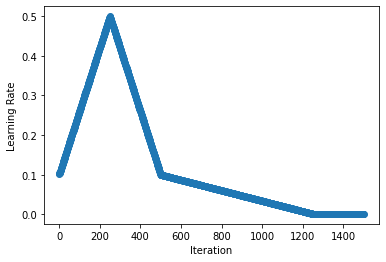

In [12]:
schedule = OneCycleSchedule(start_lr=0.1, max_lr=0.5, cycle_length=500, cooldown_length=750, finish_lr=0.001)
plot_schedule(schedule)

![lr adv onecycle](https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/doc/tutorials/lr_schedules/adv_onecycle.png) <!--notebook-skip-line-->


### Cyclical

Originally proposed by [Leslie N. Smith (2015)](https://arxiv.org/abs/1506.01186), the idea of cyclically increasing and decreasing the learning rate has been shown to give faster convergence and more optimal solutions. We implement a wrapper class that loops existing cycle-based schedules such as `TriangularSchedule` and `CosineAnnealingSchedule` to provide infinitely repeating schedules. We pass the schedule class (rather than an instance) because one feature of the `CyclicalSchedule` is to vary the `cycle_length` over time as seen in [Ilya Loshchilov, Frank Hutter (2016)](https://arxiv.org/abs/1608.03983) using `cycle_length_decay`. Another feature is the ability to decay the cycle magnitude over time with `cycle_magnitude_decay`.

In [13]:
class CyclicalSchedule():
    def __init__(self, schedule_class, cycle_length, cycle_length_decay=1, cycle_magnitude_decay=1, **kwargs):
        """
        schedule_class: class of schedule, expected to take `cycle_length` argument
        cycle_length: iterations used for initial cycle (int)
        cycle_length_decay: factor multiplied to cycle_length each cycle (float)
        cycle_magnitude_decay: factor multiplied learning rate magnitudes each cycle (float)
        kwargs: passed to the schedule_class
        """
        self.schedule_class = schedule_class
        self.length = cycle_length
        self.length_decay = cycle_length_decay
        self.magnitude_decay = cycle_magnitude_decay
        self.kwargs = kwargs

    def __call__(self, iteration):
        cycle_idx = 0
        cycle_length = self.length
        idx = self.length
        while idx <= iteration:
            cycle_length = math.ceil(cycle_length * self.length_decay)
            cycle_idx += 1
            idx += cycle_length
        cycle_offset = iteration - idx + cycle_length

        schedule = self.schedule_class(cycle_length=cycle_length, **self.kwargs)
        return schedule(cycle_offset) * self.magnitude_decay**cycle_idx

As an example, we implement the triangular cyclical schedule presented in ["Cyclical Learning Rates for Training Neural Networks" by Leslie N. Smith (2015)](https://arxiv.org/abs/1506.01186). We use slightly different terminology to the paper here because we use `cycle_length` that is twice the 'stepsize' used in the paper. We repeat cycles, each with a length of 500 iterations and lower and upper learning rate bounds of 0.5 and 2 respectively.

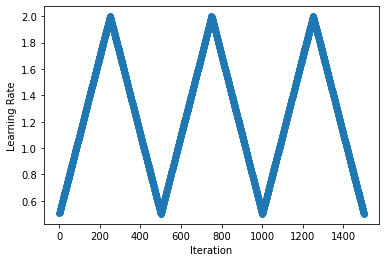

In [14]:
schedule = CyclicalSchedule(TriangularSchedule, min_lr=0.5, max_lr=2, cycle_length=500)
plot_schedule(schedule)

![lr adv cyclical](https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/doc/tutorials/lr_schedules/adv_cyclical.png) <!--notebook-skip-line-->


And lastly, we implement the scheduled used in ["SGDR: Stochastic Gradient Descent with Warm Restarts" by Ilya Loshchilov, Frank Hutter (2016)](https://arxiv.org/abs/1608.03983). We repeat cosine annealing schedules, but each time we halve the magnitude and double the cycle length.

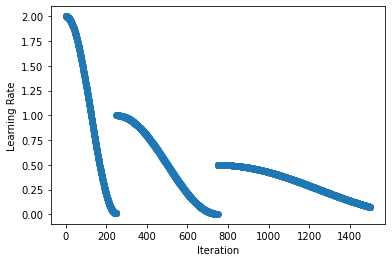

In [15]:
schedule = CyclicalSchedule(CosineAnnealingSchedule, min_lr=0.01, max_lr=2,
                            cycle_length=250, cycle_length_decay=2, cycle_magnitude_decay=0.5)
plot_schedule(schedule)

![lr adv sgdr](https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/doc/tutorials/lr_schedules/adv_sgdr.png) <!--notebook-skip-line-->


**_Want to learn more?_** Checkout the "Learning Rate Schedules" tutorial for a more basic overview of learning rates found in `mx.lr_scheduler`, and an example of how to use them while training your own models.

<!-- INSERT SOURCE DOWNLOAD BUTTONS -->